# Climate Analysis


### Data Cleaning

In [105]:
import altair as alt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact


In [106]:
# import data
df = pd.read_csv('data/Environment_Temperature_change_E_All_Data_NOFLAG.csv', encoding='latin-1')

In [107]:
df.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,7001,January,7271,Temperature change,°C,0.777,0.062,2.744,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,2,Afghanistan,7001,January,6078,Standard Deviation,°C,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,2,Afghanistan,7002,February,7271,Temperature change,°C,-1.743,2.465,3.919,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,2,Afghanistan,7002,February,6078,Standard Deviation,°C,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,2,Afghanistan,7003,March,7271,Temperature change,°C,0.516,1.336,0.403,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [108]:
# Rename columns
df.columns = df.columns.str.lower().str.replace('y', '')

# Drop columns
df.drop(columns=['area code', 'months code', 'element code', 'unit'], inplace=True)

df['months'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December',
       'Dec\x96Jan\x96Feb', 'Mar\x96Apr\x96May', 'Jun\x96Jul\x96Aug',
       'Sep\x96Oct\x96Nov', 'Meteorological year'], dtype=object)

In [109]:
months_replace = {'Dec\x96Jan\x96Feb': 'quarter_1', 'Mar\x96Apr\x96May': 'quarter_2', 'Jun\x96Jul\x96Aug': 'quarter_3', 'Sep\x96Oct\x96Nov': 'quarter_4'}
df.replace(months_replace, inplace=True)

In [110]:
df.head()

,area,months,element,1961,1962,1963,1964,1965,1966,1967,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,January,Temperature change,0.777,0.062,2.744,-5.232,1.868,3.629,-1.432,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,Afghanistan,January,Standard Deviation,1.950,1.950,1.950,1.950,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,Afghanistan,February,Temperature change,-1.743,2.465,3.919,-0.202,-0.096,3.397,0.296,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,Afghanistan,February,Standard Deviation,2.597,2.597,2.597,2.597,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,Afghanistan,March,Temperature change,0.516,1.336,0.403,1.659,-0.909,-0.069,-0.759,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [136]:
# Global temperature trend
global_temp = df.melt(var_name='year', value_name='temp', id_vars=('area', 'months', 'element'))

global_temp_grouped = global_temp.groupby(['area', 'element', 'year']).mean()
annual_temp_change = global_temp_grouped.pivot_table('temp', ['area', 'year'], 'element')
annual_temp_change.reset_index(drop=False, inplace=True)
annual_temp_change = annual_temp_change.rename_axis(None, axis=1)
annual_temp_change = annual_temp_change.rename(columns={'Standard Deviation': 'sd', 'Temperature change': 'mean_temp_change'})

pd.to_datetime(annual_temp_change['year'], format='%Y')

annual_temp_change.head()

,area,year,sd,mean_temp_change
0,Afghanistan,1961,1.187765,0.027941
1,Afghanistan,1962,1.187765,-0.197471
2,Afghanistan,1963,1.187765,0.888706
3,Afghanistan,1964,1.187765,-0.905647
4,Afghanistan,1965,1.187765,-0.051824


In [137]:
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

regions = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

regions_bool = annual_temp_change.area.isin(regions)

region_temps = annual_temp_change[regions_bool]

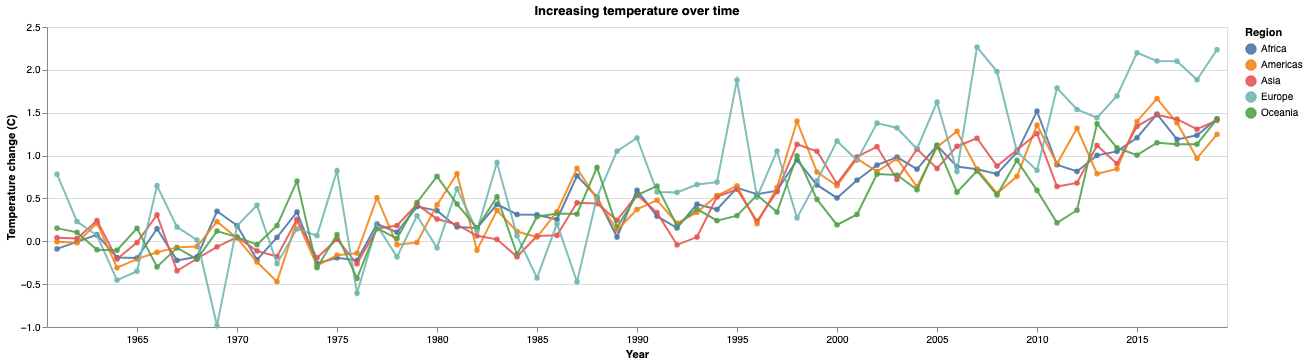

In [138]:
click = alt.selection_multi(fields=['area'], bind='legend')

scatter_plot = alt.Chart(region_temps, title="Increasing temperature over time"
                        ).mark_point(filled=True).encode(
    x=alt.X('year', title="Year", axis=alt.Axis(values=np.arange(1960, 2021, 5), labelAngle=0)),
    y=alt.Y('mean(mean_temp_change)', title="Temperature change (C)") ,
    color=alt.Color('area', title="Region"),
    tooltip='area',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2))
).add_selection(click)

line_plot = alt.Chart(region_temps).mark_line().encode(
    x='year',
    y='mean(mean_temp_change)',
    color='area',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2))
)

scatter_plot + line_plot

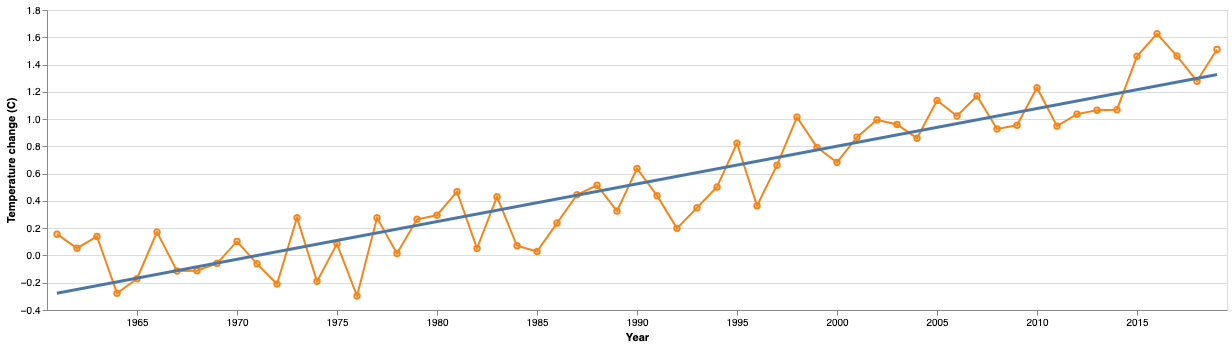

In [139]:
world_temp = annual_temp_change[annual_temp_change.area=='World']

world_plot = alt.Chart(world_temp).mark_point().encode(
    x=alt.X('year', title="Year", axis=alt.Axis(values=np.arange(1960, 2021, 5), labelAngle=0)),
    y=alt.Y('mean(mean_temp_change)', title="Temperature change (C)") ,
    color=alt.Color('area', legend=None)
)

line_plot = alt.Chart(world_temp).mark_line().encode(
    x='year',
    y='mean(mean_temp_change)',
    color='area',
)

trend = world_plot.transform_regression(
    'year', 'mean_temp_change', groupby=['months']).mark_line(size=3)


world_plot + line_plot + trend

In [148]:
region_temps

,area,year,sd,mean_temp_change
59,Africa,1961,0.337471,-0.089000
60,Africa,1962,0.337471,-0.006353
61,Africa,1963,0.337471,0.077471
62,Africa,1964,0.337471,-0.189471
63,Africa,1965,0.337471,-0.195294
...,...,...,...,...
10202,Oceania,2015,0.545647,1.004412
10203,Oceania,2016,0.545647,1.149647
10204,Oceania,2017,0.545647,1.132588
10205,Oceania,2018,0.545647,1.132706


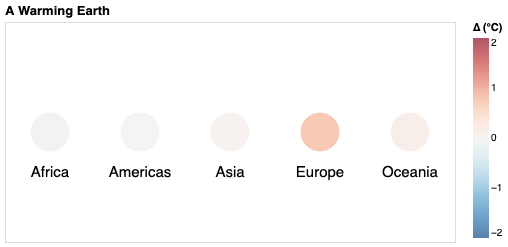

In [231]:
region_temps.loc['year'] = pd.to_numeric(region_temps.loc['year'], errors='ignore')

slider = alt.binding_range(min=1961, max=2019, step=1, name="Year")
select_year = alt.selection_single(name="year:", fields=['year'],
                                   bind=slider, init={'year': 1961})


plot = alt.Chart(region_temps, 
                 title=alt.TitleParams(
                    text="A Warming Earth",
                    anchor='start')
    ).mark_circle(size=100).encode(
        alt.X('area', axis=None),
        alt.Color('mean_temp_change', title="∆ (°C)",
                  scale=alt.Scale(scheme="redblue", reverse=True, domain=(-2, 2)))
)

(plot.encode(
    alt.Size("mean_temp_change",
             scale=alt.Scale(range=[1500, 1500]), 
             legend=None)) + 
     plot.mark_text(dy=40, size=15).encode(text='area', color=alt.value('black'))).add_selection(
    select_year
).transform_filter(
    select_year
).properties(
    width=450,
    height=220
)
